## Imports


In [1]:
%load_ext autoreload
%autoreload 2

# Datalink
# https://polybox.ethz.ch/index.php/s/d0FWhtqYRHpSwra?path=%2F

import os
import datetime
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

#os.chdir('../'); print(os.getcwd())
os.chdir('/Users/edouardpaupe/Desktop/magnify-main_DATABASE')
print(os.getcwd())

from src.utils import (
                        get_list_of_buildings,
                        load_armax_model,
                        load_weather_data,
                        add_solar_bins,
                        prepare_weather_data,
                        get_weather_forecasts,
                        plot_weather_forecasts,
                        plot_episode,
                        )
from src.env import Env
from src.agents import RB, MPC

from src.flex import (plot_power_bounds_for_episode,
                      extract_daily_zone_bounds,
                      power_to_energy_bounds,
                      max_duration_for_constant_power,
                      slice_for_episode,
                      envelope_for_zone_day,
                      )

/Users/edouardpaupe/Desktop/magnify-main_DATABASE


## Flexibility UB and LW power curves generation using MPC

#### Env and MPC initialization 

In [3]:
# Initialize the environment for the flexibility computation
env = Env(
    building_id='ep_SFH_age_0_climate_1_493',  # Select building archetype, there are 30 in total
    climate_id=0,                               # Climate scenario, there are 6 in total, each climate_id starts on 2020-01-02
    start_time=datetime.datetime(2020, 5, 3, 0, 0, 0),  # Simulation start: year, month, day, hour, minute, second
    end_time=datetime.datetime(2020, 5, 5, 0, 0, 0),   # Simulation end: year, month, day, hour, minute, second
    history_hours=8,                            # Past data provided to agent
    horizon_hours=24,                           # Future forecast provided to agent
    steps_per_hour=4,                           # Time discretization (15 min)
)
# Reset the environment to get initial observations
observations, _ = env.reset()

# Initialize the rule-based controller (RB) for comfort control during bounds computation
controller = RB(
    n_zones=env.n_zones,
    T_min=20.0,  # Minimum comfort temperature
    T_max=22.0   # Maximum comfort temperature
)

# Initialize the upper bound MPC controller (maximal heating/flexibility)
upper_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),  # Lower comfort bound
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),# Upper comfort bound
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='upper_bound'  # Objective for upper flexibility bound
)

# Initialize the lower bound MPC controller (minimal heating/flexibility)
lower_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='lower_bound'  # Objective for lower flexibility bound
)

#### Optimization

In [4]:
# Lists to store computation times for each bound
time_upp = []
time_low = []

# Main loop: run until the environment signals termination
while not env.terminated:
    # Compute upper bound (maximal flexibility) and record computation time
    t_upp = datetime.datetime.now()
    upper_bound.predict(observations)
    time_upp.append((datetime.datetime.now() - t_upp).total_seconds())

    # Compute lower bound (minimal flexibility) and record computation time
    t_low = datetime.datetime.now()
    lower_bound.predict(observations)
    time_low.append((datetime.datetime.now() - t_low).total_seconds())

    # Save the results of the current episode for both bounds
    upper_bound.save_episode()
    lower_bound.save_episode()
    
    # Use the rule-based controller to select actions for the next step
    actions = controller.predict(observations)
    observations, reward, _, done, _ = env.step(actions)  # Advance environment

# Print average computation times for upper and lower bound MPCs
print(f'Upper bound computation time: {np.mean(time_upp):.3f} seconds')
print(f'Lower bound computation time: {np.mean(time_low):.3f} seconds')

Upper bound computation time: 0.764 seconds
Lower bound computation time: 0.736 seconds


#### Upper and Lower Power Bounds extraction

In [5]:
# Heat pump nominal power [kW]
hp_power = 3  

# Number of episodes simulated
n_episodes = len(upper_bound.results["control_action"])

# Horizon length (number of lead times)
horizon_length = env.horizon_length

# Number of thermal zones
n_zones = env.n_zones

# Initialize 2D arrays: (episodes, horizon)
upper_power_bound = np.zeros((n_episodes, horizon_length))
lower_power_bound = np.zeros((n_episodes, horizon_length))

# Loop over all episodes
for t in range(n_episodes):
    # Extract upper and lower valve openings for all zones
    # shape = (time_steps, n_zones)
    u_upp = np.array([list(x.values()) for x in upper_bound.results["control_action"][t].values()])
    u_low = np.array([list(x.values()) for x in lower_bound.results["control_action"][t].values()])

    # Keep only prediction horizon (exclude history)
    u_upp = u_upp[env.history_length:, :]  # shape (horizon_length, n_zones)
    u_low = u_low[env.history_length:, :]

    # --- Average across zones (axis=1) ---
    u_upp_mean = np.mean(u_upp, axis=1)  # shape (horizon_length,)
    u_low_mean = np.mean(u_low, axis=1)

    # Convert to power and store
    upper_power_bound[t, :] = u_upp_mean * hp_power
    lower_power_bound[t, :] = u_low_mean * hp_power

print("Upper power bound shape:", upper_power_bound.shape)  # (n_episodes, horizon_length)
print("Lower power bound shape:", lower_power_bound.shape)


Upper power bound shape: (192, 96)
Lower power bound shape: (192, 96)


#### T_in extraction for UB and LB


In [ ]:

# # Number of episodes simulated
# n_episodes = len(upper_bound.results['temperature'])

# # Horizon length (number of lead times)
# horizon_length = env.horizon_length

# # Number of thermal zones
# n_zones = env.n_zones

# # Initialize 3D arrays: (episodes, horizon, zones)
# upper_temp_bound = np.zeros((n_episodes, horizon_length, n_zones))
# lower_temp_bound = np.zeros((n_episodes, horizon_length, n_zones))

# # Loop over all episodes
# for t in range(n_episodes):
#     # Extract upper and lower temperatures for all zones
#     # shape = (time_steps, n_zones)
#     T_upp = np.array([list(x.values()) for x in upper_bound.results["temperature"][t].values()])
#     T_low = np.array([list(x.values()) for x in lower_bound.results["temperature"][t].values()])

#     # Keep only prediction horizon (exclude history and extra step)
#     T_upp = T_upp[env.history_length:-1, :]  # shape (horizon_length, n_zones)
#     T_low = T_low[env.history_length:-1, :]

#     # Store temperature bounds
#     upper_temp_bound[t, :, :] = T_upp
#     lower_temp_bound[t, :, :] = T_low

# print("Upper temperature bound shape:", upper_temp_bound.shape)  # (n_episodes, horizon_length, n_zones)
# print("Lower temperature bound shape:", lower_temp_bound.shape)

# # If you want zone-averaged temperatures (similar to power bounds):
# upper_temp_avg = np.mean(upper_temp_bound, axis=2)  # shape (n_episodes, horizon_length)
# lower_temp_avg = np.mean(lower_temp_bound, axis=2)

# print("Upper temperature avg shape:", upper_temp_avg.shape)  # (n_episodes, horizon_length)
# print("Lower temperature avg shape:", lower_temp_avg.shape)

In [6]:
def plot_power_bounds_for_episode(upper_power_bound, lower_power_bound, episode_id, env):
    """
    Plot the zone-averaged upper and lower power bounds for a given episode.

    Parameters
    ----------
    upper_power_bound : np.ndarray
        Array of shape (n_episodes, horizon_length)
    lower_power_bound : np.ndarray
        Same shape as upper_power_bound
    episode_id : int
        Index of the MPC episode (0 to n_episodes-1)
    env : Env
        The environment instance (used for horizon and time info)
    """

    # Extract data for the selected episode
    upper = upper_power_bound[episode_id, :]
    lower = lower_power_bound[episode_id, :]

    # Build time axis in hours (e.g., 0–24)
    time_axis = np.arange(env.horizon_length) / env.steps_per_hour

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis, upper, label='Upper Power Bound', color='tab:red', linewidth=2)
    plt.plot(time_axis, lower, label='Lower Power Bound', color='tab:blue', linewidth=2)
    plt.fill_between(time_axis, lower, upper, color='tab:gray', alpha=0.2)

    # Labels and formatting
    plt.xlabel("Lead Time [hours]")
    plt.ylabel("Power [kW]")
    plt.title(f"Zone-Averaged Flexibility Bounds — Episode {episode_id + 1}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

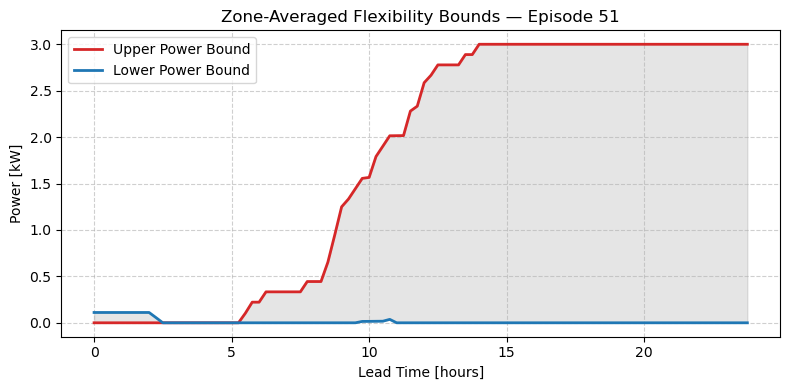

In [10]:
episode_id = 50   # e.g., plot the 11th MPC episode
plot_power_bounds_for_episode(upper_power_bound, lower_power_bound, episode_id, env)

In [ ]:
def extract_daily_building_bounds(upper_power_bound, lower_power_bound, env, save_dir=None):
    """
    Extract daily UB/LB arrays (96 x horizon_length) for each day, 
    aggregated across all zones (building-level).

    Parameters
    ----------
    upper_power_bound : np.ndarray
        Shape (n_episodes, horizon_length) — already averaged across zones
    lower_power_bound : np.ndarray
        Same shape as upper_power_bound
    env : Env
        Environment object (contains building_id, climate_id, start_time, end_time)
    save_dir : str, optional
        Directory to save .npy arrays. If None, arrays are not saved.

    Returns
    -------
    daily_bounds : dict
        Dictionary with keys like:
        "build{building_num}_clim{climate_id}_day{day_of_year}_UB" : np.ndarray (96, horizon_length)
    """
    n_episodes, n_horizon = upper_power_bound.shape
    block_size = 96  # 1 day = 96 episodes of 15 min
    n_blocks = n_episodes // block_size #divide the episodes into 24h days, each of them is gonna result in one flexibility envelope

    daily_bounds = {}

    # --- Metadata ---
    building_num = int(env.building_id.split('_')[-1]) #extract building number from id
    climate_id = env.climate_id #extract climate id

    # --- Loop over days ---
    for b in range(n_blocks):
        start_idx = b * block_size
        end_idx = start_idx + block_size

        ub_chunk = upper_power_bound[start_idx:end_idx, :]
        lb_chunk = lower_power_bound[start_idx:end_idx, :]

        current_date = (env.start_time + datetime.timedelta(days=b)).date()
        day_of_year = current_date.timetuple().tm_yday

        ub_name = f"build{building_num}_clim{climate_id}_day{day_of_year}_UB"
        lb_name = f"build{building_num}_clim{climate_id}_day{day_of_year}_LB"

        daily_bounds[ub_name] = ub_chunk
        daily_bounds[lb_name] = lb_chunk

        # Optionally save to disk without overwriting
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

            ub_path = os.path.join(save_dir, f"{ub_name}.npy")
            lb_path = os.path.join(save_dir, f"{lb_name}.npy")

            if not os.path.exists(ub_path):
                np.save(ub_path, ub_chunk)
            else:
                print(f"Skipped existing file: {ub_path}")

            if not os.path.exists(lb_path):
                np.save(lb_path, lb_chunk)
            else:
                print(f"Skipped existing file: {lb_path}")

    print(f"Extracted {n_blocks*2} daily UB/LB arrays "
          f"({n_blocks} days × 2 bounds) for building {building_num}, climate {climate_id}")

    return daily_bounds


In [ ]:
bounds_dict = extract_daily_building_bounds(
    upper_power_bound,
    lower_power_bound,
    env,
    save_dir="/Users/edouardpaupe/Desktop/magnify-main/data/power_bounds/"
)

In [ ]:
bounds_dict.keys()

In [ ]:
bounds_dict["build649_clim0_day124_UB"].shape  # (96, 96)

In [ ]:
#2) Compute the flexibility envelope
ub_day = bounds_dict['build649_clim0_day124_UB']
lb_day = bounds_dict['build649_clim0_day124_UB']
    
P_grid, durations = envelope_for_zone_day(ub_day, lb_day, dt_h=1/4,
                                          P_min=-12, P_max=14, dP=0.5)
print(durations.shape) #(53,96)

In [ ]:
# 1) Slice at a chosen lead time (episode e0)
e0 = 94 # e.g., 12th 15-min step of the day (03:00)
plt.figure(figsize=(6,4))
plt.plot(P_grid, durations[:, e0]) #print the max duration for each power level at lead time e0
plt.xlabel("Power level P [kW]")
plt.ylabel("Max sustained duration Δt [h]")
plt.title(f"Envelope slice at lead time e={e0}")
plt.grid(True); plt.tight_layout(); plt.show()

# 2) Heatmap across all lead times (P vs lead time)
plt.figure(figsize=(8,5))
plt.imshow(durations, aspect='auto', origin='lower',
           extent=[0, durations.shape[1], P_grid[0], P_grid[-1]])
plt.colorbar(label="Δt [h]")
plt.xlabel("Lead time index (episodes)")
plt.ylabel("Power level P [kW]")
plt.title("Flexibility envelope (P vs lead time, color=Δt)")
plt.tight_layout(); plt.show()

In [ ]:
def process_power_bounds(power_bounds_dir, flex_env_dir, image_dir):
    os.makedirs(flex_env_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)

    files = sorted([f for f in os.listdir(power_bounds_dir) if f.endswith(".npy")])
    ub_files = [f for f in files if f.endswith("_UB.npy")]

    print(f"Found {len(ub_files)} upper/lower bound pair files")

    for ub_file in ub_files:
        base_name = ub_file.replace("_UB.npy", "")
        lb_file = base_name + "_LB.npy"

        ub_path = os.path.join(power_bounds_dir, ub_file)
        lb_path = os.path.join(power_bounds_dir, lb_file)

        if not os.path.exists(lb_path):
            print(f"Missing lower bound file for {ub_file}, skipping.")
            continue

        # --- Load arrays ---
        ub_day = np.load(ub_path)
        lb_day = np.load(lb_path)

        # --- Compute flexibility envelope ---
        P_grid, durations = envelope_for_zone_day(
            ub_day, lb_day,
            dt_h=1/4,     # 15-min steps
            P_min=-12, P_max=14, dP=0.5
        )

        # --- Save CSV ---
        csv_path = os.path.join(flex_env_dir, f"{base_name}.csv")
        df = pd.DataFrame(
            durations,
            index=np.round(P_grid, 2),
            columns=[f"LeadTime_{i}" for i in range(durations.shape[1])]
        )
        df.index.name = "Power Level [kW]"
        df.to_csv(csv_path)
        print(f"Saved flexibility envelope CSV: {csv_path}")

        # --- Plot heatmap (fixed color scale 0–24 h) ---
        fig, ax = plt.subplots(figsize=(8, 5))
        vmin, vmax = 0, 24
        im = ax.imshow(
            durations,
            aspect="auto",
            origin="lower",
            extent=[0, durations.shape[1]*0.25, P_grid[0], P_grid[-1]],  # convert x to hours
            cmap="viridis",     # purple→yellow gradient similar to paper
            vmin=vmin, vmax=vmax
        )

        # --- Colorbar ---
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Maximum sustained duration [hour]", fontsize=11)
        cbar.ax.tick_params(labelsize=9)

        # --- Labels & title ---
        ax.set_xlabel("Lead time [hour]")
        ax.set_ylabel("Power Level [kW]")
        ax.set_title(f"Flexibility Envelope — {base_name}")
        plt.tight_layout()

        # --- Save figure ---
        img_path = os.path.join(image_dir, f"{base_name}.png")
        plt.savefig(img_path, dpi=300)
        plt.close(fig)

    print("All flexibility envelopes processed successfully!")


In [ ]:
power_bounds_dir = "/Users/edouardpaupe/Desktop/magnify-main/data/power_bounds/"
output_csv_dir = "/Users/edouardpaupe/Desktop/magnify-main/data/flex_env/"
output_img_dir = "/Users/edouardpaupe/Desktop/magnify-main/data/flex_env_images/"
process_power_bounds(power_bounds_dir, output_csv_dir, output_img_dir)

## Feature Extraction

In [ ]:
# Example building folder:

# Create the path to a specific building archetype folder
building_folder = os.path.join('armax_models', 'archetypes', 'ep_SFH_age_0_climate_0_649')  # 'armax_models/archetypes/ep_SFH_age_0_climate_0_649'

# Load the ARMAX model configuration for this building
armax_config = load_armax_model(
    building_folder_path=building_folder,  # path to the building folder
    steps_per_hour=4,                     # time discretization (4 = 15min steps)
)
#load_armax_model returns a dictionary with the ARMAX model configuration

# Select which keys to display from the ARMAX config dictionary
keys_to_show = [
    'dynamics_lags_list',  # list of lag terms for model dynamics
    'feat_length',         # length of feature vector
    'solar_terms',         # number of solar irradiance terms
    'steps_per_hour',      # time discretization
    'n_zones',             # number of zones in the building
    'building_folder',     # folder path for the building
    'model_type'           # type of ARMAX model
]

# Create a dictionary with only the selected keys and their values from armax_config
{key: armax_config[key] for key in keys_to_show}

In [ ]:
print(armax_config['armax_coef'])

In [ ]:
# Save ARMAX coefficients to CSV
armax_coef = armax_config['armax_coef']


df_coef = pd.DataFrame(armax_coef)

# Save to CSV
output_path = os.path.join('data', 'armax_coefficients.csv')
os.makedirs('data', exist_ok=True)
df_coef.to_csv(output_path)

print(f"ARMAX coefficients saved to: {output_path}")

In [2]:
# Load the climate data
path = os.path.join('armax_models','archetypes', 'meteo', 'pop_weighted')
weather_df = load_weather_data(file_path=path, climate_id=0) #returns a dataframe with weather data (timestamp, T_amb in degrees, solar irradiance in W/m2)
#climate_id corresponds to the climate scenario of the building, going from 0 to 5.
weather_df.head()



,T_amb,irrad
time,,
2020-01-01 00:00:00,-0.469978,0.0
2020-01-01 00:15:00,-0.063042,0.0
2020-01-01 00:30:00,0.343893,0.0
2020-01-01 00:45:00,0.750828,0.0
2020-01-01 01:00:00,1.157764,0.0


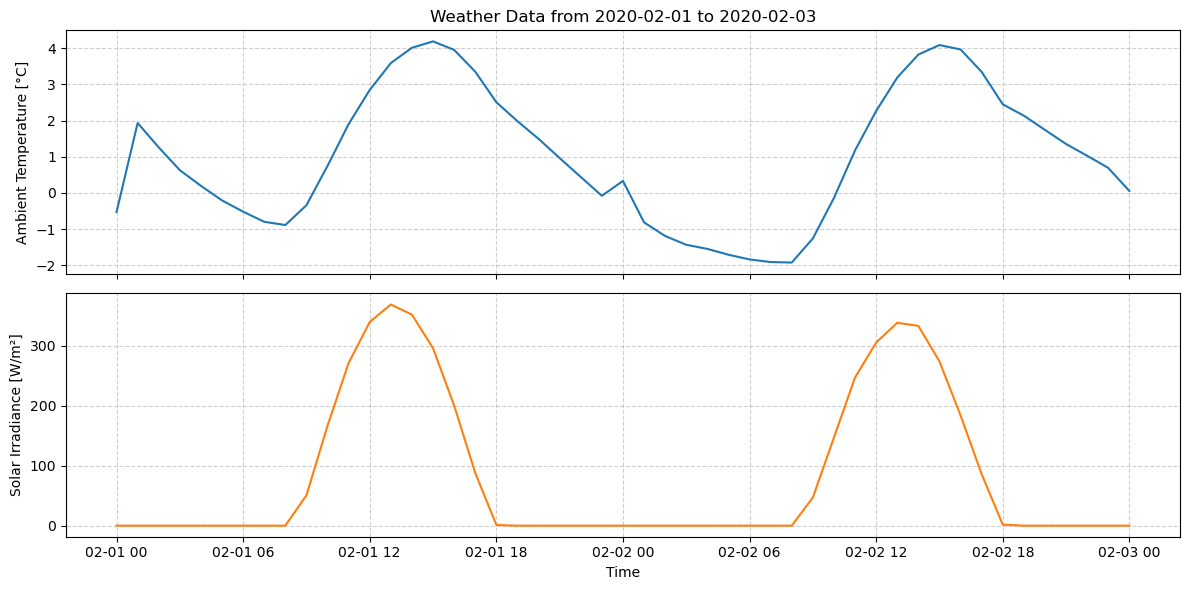

In [3]:
# Define the week to plot (e.g., from Jan 8 to Jan 15, 2020)
start_date = datetime.datetime(2020, 2, 1, 0, 0, 0)
end_date = datetime.datetime(2020, 2, 3, 0, 0, 0)

# Filter the dataframe for the specified week
week_data = weather_df.loc[start_date:end_date]

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot ambient temperature
ax1.plot(week_data.index, week_data['T_amb'], color='tab:blue', linewidth=1.5)
ax1.set_ylabel('Ambient Temperature [°C]')
ax1.set_title(f'Weather Data from {start_date.date()} to {end_date.date()}')
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot solar irradiance
ax2.plot(week_data.index, week_data['irrad'], color='tab:orange', linewidth=1.5)
ax2.set_xlabel('Time')
ax2.set_ylabel('Solar Irradiance [W/m²]')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# Save weather_df to CSV with time, T_amb, and irrad columns
output_path = os.path.join('data', 'weather_data_climate_0.csv')
os.makedirs('data', exist_ok=True)

# Reset index to make 'time' a column instead of the index
weather_df.reset_index().to_csv(output_path, index=False)

print(f"Weather data saved to: {output_path}")

In [2]:
# Save weather_df to CSV with time, T_amb, and irrad columns; for all climate scenarios (0 to 5)
path = os.path.join('armax_models', 'archetypes', 'meteo', 'pop_weighted')
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

for climate_id in range(6):  # Climate IDs from 0 to 5
    # Load weather data for this climate scenario
    weather_df = load_weather_data(file_path=path, climate_id=climate_id)
    
    # Define output path
    output_path = os.path.join(output_dir, f'weather_data_climate_{climate_id}.csv')
    
    # Reset index to make 'time' a column and save to CSV
    weather_df.reset_index().to_csv(output_path, index=False)
    
    print(f"Weather data for climate {climate_id} saved to: {output_path}")

print("All weather data files saved successfully!")

NameError: name 'os' is not defined